## 今回はJリーグの観客動員数を予測するモデルを作る
### データ
- train ==> 2012,2013,2014年前半のデータ、yもある
- test_data ==> 2014年後半のデータ、yがない(yを予測)
### 手順
- 1.trainデータのx(説明変数)とy(被説明変数)から線形回帰モデル(lr)を作る
- 2.線形回帰モデル(lr)にtest_data(yがないデータ)を入れて、yを予測する

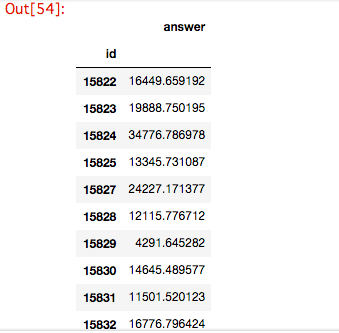

In [54]:
#最終形
answer_df

,answer
id,
15822,16449.659192
15823,19888.750195
15824,34776.786978
15825,13345.731087
15827,24227.171377
15828,12115.776712
15829,4291.645282
15830,14645.489577
15831,11501.520123


In [1]:
#ライブラリの用意
#import [ライブラリ名] as エイリアス

# pandas: データフレーム操作のためのライブラリ
import pandas as pd
#numpy: 科学計算のためのライブラリ
import numpy as np
#seaborn 描画のためのライブラリ
import seaborn as sns
#matplotlib 描画のためのライブラリ
import matplotlib.pyplot as plt 
#常にプロットが表示されるようにする
%matplotlib inline 

In [2]:
data = pd.read_csv('new_jleague.csv')# read_csv関数でcsvファイルを読み込む
#以下の変数を読み込む
pickup_var = ['y', 'home_team','away','stage','stadium', 'capa', 'gameday', 'humidity']
data = data.loc[:, pickup_var] #locメソッドを使ってpickup_varの中の変数の列に限定する
data.head() #head()で先頭5行が表示される。変数の確認のため

,y,home_team,away,stage,stadium,capa,gameday,humidity
0,18250.0,ベガルタ仙台,鹿島アントラーズ,Ｊ１,ユアテックスタジアム仙台,19694,03/10(土),66%
1,24316.0,名古屋グランパス,清水エスパルス,Ｊ１,豊田スタジアム,40000,03/10(土),43%
2,17066.0,ガンバ大阪,ヴィッセル神戸,Ｊ１,万博記念競技場,21000,03/10(土),41%
3,29603.0,サンフレッチェ広島,浦和レッズ,Ｊ１,エディオンスタジアム広島,50000,03/10(土),52%
4,25353.0,コンサドーレ札幌,ジュビロ磐田,Ｊ１,札幌ドーム,39232,03/10(土),32%


In [3]:
#testデータとtrainデータを分割
test = data[data['y'].isnull()]
train = data.iloc[:1953,:]

#testデータとtrainデータの長さをprintで表示
print(len(test))
print(len(train))

#ややこしい書き方になるがtestデータは用いていない, 以下のtest_dataを用いている。

313
1953


In [4]:
#csvファイルを読み込む
import codecs
with codecs.open( 'new_test.csv',"r", "Shift-JIS", "ignore") as file:
    test_data= pd.read_table(file, delimiter=",")

In [5]:
#trainデータと同様
pickup_var = ['id', 'home_team','away', 'capa', 'gameday', 'humidity']
test_data = test_data.loc[:, pickup_var]
id_var = ['id']
test_data_id = test_data.loc[:, id_var]
test_data.head()

,id,home_team,away,capa,gameday,humidity
0,15822,ベガルタ仙台,大宮アルディージャ,19694,08/02(土),70%
1,15823,鹿島アントラーズ,サンフレッチェ広島,40728,08/02(土),65%
2,15824,浦和レッズ,ヴィッセル神戸,63700,08/02(土),58%
3,15825,柏レイソル,川崎フロンターレ,15349,08/02(土),76%
4,15827,アルビレックス新潟,セレッソ大阪,42300,08/02(土),68%


In [6]:
#変数を処理

#about: gameday
gameday = train['gameday']
del train['gameday']

#土日祝=>1, それ以外=>0　となるようなダミー変数を作る関数
#ex. '03/10(土)' => 1, '10/24(金)' => 0, '05/03(木・祝)''　=> 1, 
def holiday_judge(dates):
    results = []
    for date in dates:
        if ('土' in date) or ('日' in date) or ('祝' in date) :
            results.append(1)
        else:
            results.append(0)
    return results

#pd.DataFrameでデータフレーム化, columns=[columns_name] で列名を指定
dates = pd.DataFrame(holiday_judge(gameday), columns=['gameday'])
#pd.concatで2つのデータフレームを結合, axis=で結合する方向を指定(axis=1=>横方向, axis=0 => 縦方向)
train = pd.concat([train, dates], axis=1)

#about:humidity
#ex. 67% => 67
train['humidity'] = train['humidity'].str.rstrip('%')

#about:stage Ｊ１==>1 J2==>0
train['stage'] = np.where(train['stage'] == 'Ｊ１', 1, 0)

In [7]:
#groupby関数で'home_team','away', 'stadium'ごとに集計, mean()関数で平均を出す
home = train.groupby('home_team')['y'].mean()
away = train.groupby('away')['y'].mean()
stadium = train.groupby('stadium')['y'].mean()

In [8]:
#home => home_df
#away => away_df
#stadium => stadium_df 
#にデータフレーム化

#[DataFrame].columns = [name]でデータフレームの列名を指定
home_df = pd.DataFrame(home)

home_df.columns =[ 'home_y']

away_df = pd.DataFrame(away)
away_df.columns =[ 'away_y']

stadium_df = pd.DataFrame(stadium)
stadium_df.columns =[ 'stadium_y']

In [10]:
#merge関数でtrainに'home_df','away_df','stadium_df'を結合
b = pd.merge(train, home_df, left_on='home_team', right_index=True)
b = pd.merge(b, away_df, left_on='away', right_index=True)
b = pd.merge(b, stadium_df, left_on='stadium', right_index=True)

In [11]:
#'y'と他の変数との相関を見る
b.corr()['y']

y            1.000000
stage        0.668457
capa         0.684865
gameday      0.089069
home_y       0.861647
away_y       0.668352
stadium_y    0.856059
Name: y, dtype: float64

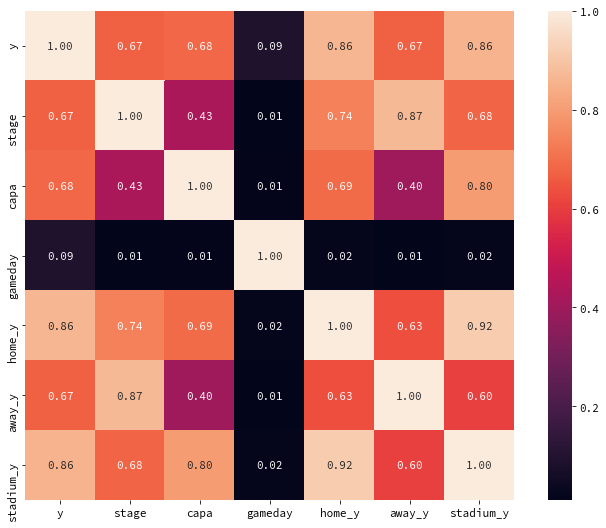

In [12]:
#seabornライブラリを使う

#figureを作成, figsizeで(縦, 横)の長さを指定
plt.figure(figsize=(12, 9))
# annot : 数値を表示するかどうか(annotation)
# square: 四角を正方形に合わせるかどうか
# fmt   : 表示する数値の形式(formatting)
sns.heatmap(b.corr(), annot=True, square=True, fmt='.2f')
plt.show()

In [13]:
# ==> capa, gameday, home_y, away_y, humidity, address_yを変数として用いる

In [14]:
#isort_index: ndexの値に従ってsortしてくれる関数 <=> sort_values　もある
b = b.sort_index()
b.head()

,y,home_team,away,stage,stadium,capa,humidity,gameday,home_y,away_y,stadium_y
0,18250.0,ベガルタ仙台,鹿島アントラーズ,1,ユアテックスタジアム仙台,19694,66,1,15353.904762,20289.139535,15309.292683
1,24316.0,名古屋グランパス,清水エスパルス,1,豊田スタジアム,40000,43,1,17226.744186,16187.348837,20624.360000
2,17066.0,ガンバ大阪,ヴィッセル神戸,1,万博記念競技場,21000,41,1,13449.891304,11431.478261,13449.891304
3,29603.0,サンフレッチェ広島,浦和レッズ,1,エディオンスタジアム広島,50000,52,1,16494.209302,23127.880952,16494.209302
4,25353.0,コンサドーレ札幌,ジュビロ磐田,1,札幌ドーム,39232,32,1,10837.254902,14579.577778,13362.200000


In [15]:
#copy()関数でbのコピーを取る
c = b.copy()
c.head()

,y,home_team,away,stage,stadium,capa,humidity,gameday,home_y,away_y,stadium_y
0,18250.0,ベガルタ仙台,鹿島アントラーズ,1,ユアテックスタジアム仙台,19694,66,1,15353.904762,20289.139535,15309.292683
1,24316.0,名古屋グランパス,清水エスパルス,1,豊田スタジアム,40000,43,1,17226.744186,16187.348837,20624.360000
2,17066.0,ガンバ大阪,ヴィッセル神戸,1,万博記念競技場,21000,41,1,13449.891304,11431.478261,13449.891304
3,29603.0,サンフレッチェ広島,浦和レッズ,1,エディオンスタジアム広島,50000,52,1,16494.209302,23127.880952,16494.209302
4,25353.0,コンサドーレ札幌,ジュビロ磐田,1,札幌ドーム,39232,32,1,10837.254902,14579.577778,13362.200000


In [16]:
#bから　'away', 'stadium', 'home_team', 'stage', 'stadium_y'を削除

del b['away']
del b['stadium']
del b['home_team']
del b['stage']
del b['stadium_y']

In [17]:
#外れ値の除去

In [18]:
b.iloc[1385]

y                 0
capa          63700
humidity         23
gameday           1
home_y      36382.4
away_y      16187.3
Name: 1385, dtype: object

In [19]:
b = b.drop(1385)

In [20]:
#外れ値の除去の確認
np.where(b.y == 0)

(array([], dtype=int64),)

In [21]:
np.where(b['y']>60000)

(array([1843]),)

In [22]:
#ilocで1840から1845行を指定
b.iloc[1840:1845]

,y,capa,humidity,gameday,home_y,away_y
1841,13743.0,15100,61,1,8149.580000,23127.880952
1842,15512.0,50000,88,1,16494.209302,16187.348837
1843,28484.0,72327,66,1,24603.833333,17452.428571
1844,62632.0,72327,33,1,24603.833333,15577.162791
1845,13583.0,18500,27,1,9522.277778,9585.326531


In [23]:
#外れ値の除去
b = b.drop(1844)

In [24]:
#外れ値の除去の確認
np.where(b.y == 62632)

(array([], dtype=int64),)

In [25]:
#各列に欠損値がないかチェック
b.isnull().sum()

y           0
capa        0
humidity    0
gameday     0
home_y      0
away_y      0
dtype: int64

In [26]:
#capa, gameday, home_y, away_y, humidity, address_yを変数として用いる
X = b.reindex(columns=['capa','humidity','gameday','home_y','away_y']).values
y = b.reindex(columns=['y']).values.astype('float64')

In [27]:
#1次関数の回帰
from sklearn.linear_model import LinearRegression

# 線形回帰インスタンスの生成
lr = LinearRegression()

# 重回帰分析の学習
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
#testデータにもtrainデータと同様の処理を行う 
#1. 変数: humidity, gamedayを処理
#2. home_y, away_y を集計, 連結

In [29]:
b.head()

,y,capa,humidity,gameday,home_y,away_y
0,18250.0,19694,66,1,15353.904762,20289.139535
1,24316.0,40000,43,1,17226.744186,16187.348837
2,17066.0,21000,41,1,13449.891304,11431.478261
3,29603.0,50000,52,1,16494.209302,23127.880952
4,25353.0,39232,32,1,10837.254902,14579.577778


In [30]:
test_data.head()

,id,home_team,away,capa,gameday,humidity
0,15822,ベガルタ仙台,大宮アルディージャ,19694,08/02(土),70%
1,15823,鹿島アントラーズ,サンフレッチェ広島,40728,08/02(土),65%
2,15824,浦和レッズ,ヴィッセル神戸,63700,08/02(土),58%
3,15825,柏レイソル,川崎フロンターレ,15349,08/02(土),76%
4,15827,アルビレックス新潟,セレッソ大阪,42300,08/02(土),68%


In [31]:
#about: gameday
gameday = test_data['gameday']
del test_data['gameday']

def holiday_judge(dates):
    results = []
    for date in dates:
        if ('土' in date) or ('日' in date) or ('祝' in date) :
            results.append(1)
        else:
            results.append(0)
    return results

dates = pd.DataFrame(holiday_judge(gameday), columns=['gameday'])
test_data = pd.concat([test_data, dates], axis=1)

#about:humidity
test_data['humidity'] = test_data['humidity'].str.rstrip('%')

In [32]:
test_data.head()

,id,home_team,away,capa,humidity,gameday
0,15822,ベガルタ仙台,大宮アルディージャ,19694,70,1
1,15823,鹿島アントラーズ,サンフレッチェ広島,40728,65,1
2,15824,浦和レッズ,ヴィッセル神戸,63700,58,1
3,15825,柏レイソル,川崎フロンターレ,15349,76,1
4,15827,アルビレックス新潟,セレッソ大阪,42300,68,1


In [33]:
c.head()

,y,home_team,away,stage,stadium,capa,humidity,gameday,home_y,away_y,stadium_y
0,18250.0,ベガルタ仙台,鹿島アントラーズ,1,ユアテックスタジアム仙台,19694,66,1,15353.904762,20289.139535,15309.292683
1,24316.0,名古屋グランパス,清水エスパルス,1,豊田スタジアム,40000,43,1,17226.744186,16187.348837,20624.360000
2,17066.0,ガンバ大阪,ヴィッセル神戸,1,万博記念競技場,21000,41,1,13449.891304,11431.478261,13449.891304
3,29603.0,サンフレッチェ広島,浦和レッズ,1,エディオンスタジアム広島,50000,52,1,16494.209302,23127.880952,16494.209302
4,25353.0,コンサドーレ札幌,ジュビロ磐田,1,札幌ドーム,39232,32,1,10837.254902,14579.577778,13362.200000


In [34]:
home_mean_df = c[['home_team', 'home_y']]
home_mean_df.head()

,home_team,home_y
0,ベガルタ仙台,15353.904762
1,名古屋グランパス,17226.744186
2,ガンバ大阪,13449.891304
3,サンフレッチェ広島,16494.209302
4,コンサドーレ札幌,10837.254902


In [35]:
away_mean_df = c[['home_team', 'away_y']]
away_mean_df.head()

,home_team,away_y
0,ベガルタ仙台,20289.139535
1,名古屋グランパス,16187.348837
2,ガンバ大阪,11431.478261
3,サンフレッチェ広島,23127.880952
4,コンサドーレ札幌,14579.577778


In [36]:
#home_team_dfからhome_teamが一意になっているデータだけを取り出す.
home_mean_unq = home_mean_df[-home_mean_df[['home_team']].duplicated()]
home_mean_unq.head()

,home_team,home_y
0,ベガルタ仙台,15353.904762
1,名古屋グランパス,17226.744186
2,ガンバ大阪,13449.891304
3,サンフレッチェ広島,16494.209302
4,コンサドーレ札幌,10837.254902


In [37]:
away_mean_unq = away_mean_df[-away_mean_df[['home_team']].duplicated()]
away_mean_unq.head()

,home_team,away_y
0,ベガルタ仙台,20289.139535
1,名古屋グランパス,16187.348837
2,ガンバ大阪,11431.478261
3,サンフレッチェ広島,23127.880952
4,コンサドーレ札幌,14579.577778


In [38]:
test_data2 = pd.merge(test_data, home_mean_unq, on='home_team')
test_data2.head()

,id,home_team,away,capa,humidity,gameday,home_y
0,15822,ベガルタ仙台,大宮アルディージャ,19694,70,1,15353.904762
1,15840,ベガルタ仙台,清水エスパルス,19694,83,1,15353.904762
2,15863,ベガルタ仙台,横浜Ｆ・マリノス,19694,75,1,15353.904762
3,15885,ベガルタ仙台,鹿島アントラーズ,19694,44,1,15353.904762
4,15903,ベガルタ仙台,ＦＣ東京,19694,66,1,15353.904762


In [39]:
test_data3 = pd.merge(test_data2, away_mean_unq, on='home_team')
test_data3.head()

,id,home_team,away,capa,humidity,gameday,home_y,away_y
0,15822,ベガルタ仙台,大宮アルディージャ,19694,70,1,15353.904762,20289.139535
1,15840,ベガルタ仙台,清水エスパルス,19694,83,1,15353.904762,20289.139535
2,15863,ベガルタ仙台,横浜Ｆ・マリノス,19694,75,1,15353.904762,20289.139535
3,15885,ベガルタ仙台,鹿島アントラーズ,19694,44,1,15353.904762,20289.139535
4,15903,ベガルタ仙台,ＦＣ東京,19694,66,1,15353.904762,20289.139535


In [40]:
#sort_values('id'): 'id'列の値に従って行をsort
test_data3 = test_data3.sort_values('id')
test_data3.head()

,id,home_team,away,capa,humidity,gameday,home_y,away_y
0,15822,ベガルタ仙台,大宮アルディージャ,19694,70,1,15353.904762,20289.139535
8,15823,鹿島アントラーズ,サンフレッチェ広島,40728,65,1,15814.738095,23127.880952
16,15824,浦和レッズ,ヴィッセル神戸,63700,58,1,36382.441860,16722.571429
24,15825,柏レイソル,川崎フロンターレ,15349,76,1,12885.930233,17623.627907
32,15827,アルビレックス新潟,セレッソ大阪,42300,68,1,25154.928571,15682.930233


In [41]:
del test_data3['id']
del test_data3['home_team']
del test_data3['away']

In [42]:
b.head()

,y,capa,humidity,gameday,home_y,away_y
0,18250.0,19694,66,1,15353.904762,20289.139535
1,24316.0,40000,43,1,17226.744186,16187.348837
2,17066.0,21000,41,1,13449.891304,11431.478261
3,29603.0,50000,52,1,16494.209302,23127.880952
4,25353.0,39232,32,1,10837.254902,14579.577778


In [43]:
test_data3.head()

,capa,humidity,gameday,home_y,away_y
0,19694,70,1,15353.904762,20289.139535
8,40728,65,1,15814.738095,23127.880952
16,63700,58,1,36382.441860,16722.571429
24,15349,76,1,12885.930233,17623.627907
32,42300,68,1,25154.928571,15682.930233


In [44]:
#[・].valuesはvalueだけを取り出すメソッド
#lr.predictでtest_data3の説明変数たちからyを予測する
answer = lr.predict(test_data3.values)

# pd.DataFrame で answer　をデータフレーム化。columns=, inde= でそれぞれ列名、行名を指定
answer_df = pd.DataFrame(answer, columns=['answer'], index=test_data_id ['id'])

In [45]:
answer_df.head()

,answer
id,
15822,16449.659192
15823,19888.750195
15824,34776.786978
15825,13345.731087
15827,24227.171377


In [46]:
#csvファイルで提出するのでto_csv関数でcsvとして出力
answer_df.to_csv('answer.csv')

In [47]:
#おまけ: 3次で回帰してみる

# 3次関数の変数変換
from sklearn.preprocessing import PolynomialFeatures
cube = PolynomialFeatures(degree=3)    # 3次の多項式基底を生成
X_cube = cube.fit_transform(X) # 生成した基底関数で変数変換を実行

# 線形回帰のインスタンスを生成
model_cube = LinearRegression()
# 変換後の変数を利用して実行
model_cube.fit(X_cube, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
X_cube.shape

(1951, 56)

In [49]:
X2 = test_data3.values
X2_cube = cube.fit_transform(X2)

In [50]:
X2.shape

(313, 5)

In [51]:
X2_cube.shape

(313, 56)

In [52]:
answer_df2 = pd.DataFrame(model_cube.predict(X2_cube), columns=['answer'], index=test_data_id ['id'])

In [53]:
answer_df2.head()

,answer
id,
15822,15380.333355
15823,24572.655958
15824,37324.114944
15825,11865.339391
15827,23997.406383


In [ ]:
answer_df2.to_csv('answer2.csv')